In [4]:
import time, sys, os
import h5py	 
import numpy as np
import scipy
import fsps
import sedpy
import prospect
import emcee
import astropy
import math
from matplotlib.pyplot import *
from prospect.fitting import fit_model
from prospect.fitting import lnprobfn
import matplotlib.pyplot as plt

# func.py has some extra functionalities
from func import *

In [5]:
# Change some figure settings
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '9'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '9'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '5'}) 
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 24})

# Data preparation

In [13]:
# run_params are important params through the whole fitting procedure
run_params = {}
run_params["snr"] = 4
run_params["object_redshift"] = 0.824
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

In [7]:
# Get the raw photometry data
from astropy.io.votable import parse
votable = parse('/home/kaiwen/work/data/m87.vot')
table = votable.get_first_table()
data=table.array
raw_data={}
leng=(len(data))

In [9]:
# construct a list of all frequency to sort out the order
# all the filters should be first loaded into: .../sedpy/build/lib/sedpy/data/filters
# my filter files can be found at filters folder
raw_data['filtername']=[]
raw_data['flux']=[]
raw_data['unc']=[]
freq = []
name_tem = []
maxi=[]
for table in votable.iter_tables():
    
    for i in range(0,leng):
        name = data[i][7].lower()
        f = data[i][4]
        length = len(name)
        Filter = ''
        for j in range(0,length):
            if name[j]==":":
                Filter+="_"
            elif name[j]=="/":
                Filter+="_"
            elif name[j]=="'":
                pass
            else:
                Filter+=name[j]
        ######################################        
        # below are some changes only for Hengxiao's object 
        # for other objects you can delete them and add what is necessary
        if Filter == 'pan-starrs_ps1_r':
            Filter = 'sdss_r'
            f = 4.799e5
        elif Filter == 'gaia_gaia2_gbp':
            Filter = 'sdss_g'
            f = 6.2198e5
        elif Filter == 'gaia_gaia2_grp':
            Filter = 'sdss_i'
            f = 3.9266e5
        elif Filter == 'pan-starrs_ps1_g':
            Filter = 'sdss_g'
            f = 6.2198e5
        elif Filter == 'pan-starrs_ps1_i':
            Filter = 'sdss_i'
            f = 3.9266e5
        elif Filter == 'vista_j':
            Filter = '2mass_j'
        elif Filter == 'vista_h':
            Filter = '2mass_h'
        elif Filter == '_=3.6um':
            Filter = 'spitzer_irac_3.6'
            f = 84449
        elif Filter == '_=4.5um':
            Filter = 'wise_w2'
            f = 65172
        elif Filter == 'spitzer_irac_4.5':
            Filter = 'wise_w2'
            f = 65172
        elif Filter == 'gaia_gaia2_g':
            Filter = 'sdss_r'
            f = 4.799e5
        elif Filter == 'gaia_g':
            Filter = 'sdss_r'
            f = 4.799e5
        elif Filter == 'pan-starrs_ps1_z':
            Filter = 'sdss_z'
            f = 3.3244e5
        elif Filter == 'vista_ks':
            Filter = '2mass_ks'
            f = 1.3855e5
        else:
            pass
        ######################################
        name_tem.append(Filter)
        freq.append(f)
    
    for i in range(0,leng):
        maxi.append(freq[i])
    for k in range(0,leng):
        max_value = max(maxi)
        max_index = maxi.index(max_value)
        # then we can store the data to raw_data for later use
        # change the filter name 
        raw_data['flux'].append(data[max_index][5])
        raw_data['filtername'].append(name_tem[max_index])
        
        # Create error to some bins 
        if type(data[max_index][6])!= np.float32:
            raw_data['unc'].append((data[max_index][5])/5)
        else:
            raw_data['unc'].append(data[max_index][6])
        
        maxi[max_index]=0
    pass

In [10]:
# now we need to combine/average the data for same filter and propogate the error
# we can also pre-process our data here 
fit_data={}
fit_data['filtername']=[]
fit_data['flux']=[]
fit_data['unc']=[]
i=0
while i<len(raw_data['flux']):
    flux = 0
    unc = 0
    
    ### select the data we need for the fit    
    data_list = [ 'galex_fuv', 'galex_nuv','sdss_u', 'sdss_g', 'sdss_r','sdss_i', 
                 'sdss_z', 'ukidss_j','ukidss_h', 'ukidss_k', 'wise_w1', 'spitzer_irac_3.6', '_=3.6um', 
                 'spitzer_irac_4.5', '_=4.5um', 'wise_w2', 'spitzer_irac_5.8', 'spitzer_irac_8.0', 'wise_w3', 
                 'spitzer_mips_24', '_=70um', '_=160um', '_=350um']

    if data_list.count(raw_data['filtername'][i])==0:
        i+=1
        continue
        
    ###
    time = raw_data['filtername'].count(raw_data['filtername'][i])
    if raw_data['filtername'][i]=='_=70um':
        fit_data['filtername'].append('spitzer_mips_70')
    elif raw_data['filtername'][i]=='_=160um':
        fit_data['filtername'].append('spitzer_mips_160')
    else:
        fit_data['filtername'].append(raw_data['filtername'][i])    
    for j in range(i,i+time):
        flux += (raw_data['flux'][j])/time
    fit_data['flux'].append(flux)
    
    for k in range(i,i+time):
        unc += raw_data['unc'][k]/time
    unc = max(unc,flux/5)
    fit_data['unc'].append(unc)
    i+=time
    
print((fit_data['filtername']))

['galex_fuv', 'galex_nuv', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z', 'ukidss_j', 'ukidss_h', 'ukidss_k', 'wise_w1', 'spitzer_irac_3.6', 'wise_w2', 'spitzer_irac_5.8', 'spitzer_irac_8.0', 'wise_w3', 'spitzer_mips_24', 'spitzer_mips_70', 'spitzer_mips_160', '_=350um']


# Build obs

In [11]:
def build_obs(fit_data, snr=10, ldist=10.0, **extras):
    
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}
    # These are the names of the relevant filters,  
    # in the same order as the photometric data (see below)
    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
    obs["filters"] = sedpy.observate.load_filters(fit_data['filtername'])
    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    
    obs["maggies"] = [x / 3631 for x in fit_data['flux']]
    obs['maggies']=np.array(obs['maggies'])
    
    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
    obs["maggies_unc"] = [x / 3631 for x in fit_data["unc"]]
    obs['maggies_unc']=np.array(obs['maggies_unc'])

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    obs["phot_mask"] = np.array([True for f in obs["filters"]])
    
    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms   
    obs["spectrum"] = None
    obs["wavelength"] = None
    obs['unc'] = None
    obs['mask'] = None
    
    # if we have spectrum,we can do the following
    '''data = fits.open('/home/kaiwen/work/spec-8124-56954-0690.fits')
    z = data[2].data['z'][0]
    lam = 10**data[1].data['loglam']    # OBS wavelength [A]
    flux = data[1].data['flux']*3.34e4*lam**2/3631.*1.e-17 *0.9    # OBS flux [erg/s/cm^2/A] to maggies  JY/3631
    err = 1./np.sqrt(data[1].data['ivar'])*3.34e4*lam**2/3631.*1.e-17   # 1 sigma error

    obs["wavelength"] = lam
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = smooth(flux,5)
    # (spectral uncertainties are given here)
    obs['unc'] = smooth(err,5)
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = np.ones_like(lam,dtype=bool)'''
    
    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)
    
    # Due to some unknown reason, fix_obs may change true to false in phot_mask.We do it again after the function.
    obs["phot_mask"] = np.array([True for f in obs["filters"]])
    return obs

In [14]:
obs = build_obs(fit_data,**run_params)
# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

Obs Dictionary Keys:

['phot_mask', 'phot_wave', 'ndof', 'mask', 'spectrum', 'maggies_unc', 'filternames', 'unc', 'maggies', 'filters', 'wavelength', 'logify_spectrum']

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_fuv), <class 'sedpy.observate.Filter'>(galex_nuv), <class 'sedpy.observate.Filter'>(sdss_u), <class 'sedpy.observate.Filter'>(sdss_g), <class 'sedpy.observate.Filter'>(sdss_r), <class 'sedpy.observate.Filter'>(sdss_i), <class 'sedpy.observate.Filter'>(sdss_z), <class 'sedpy.observate.Filter'>(ukidss_j), <class 'sedpy.observate.Filter'>(ukidss_h), <class 'sedpy.observate.Filter'>(ukidss_k), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(spitzer_irac_3.6), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(spitzer_irac_5.8), <class 'sedpy.observate.Filter'>(spitzer_irac_8.0), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(spitzer_mips_24), <class 'sedpy.observate.Filter'>(sp

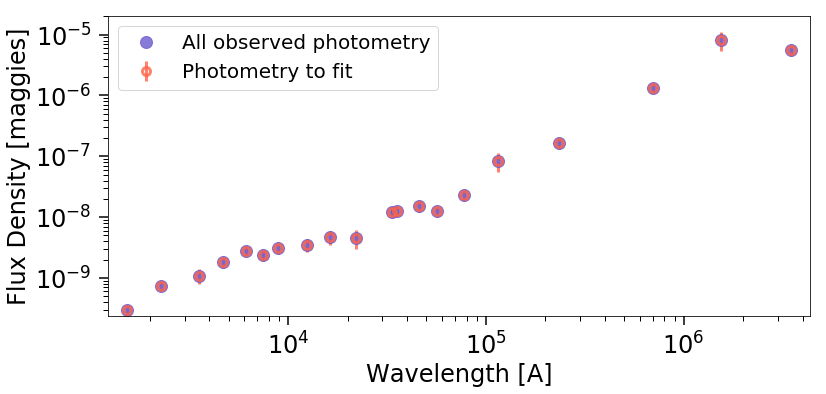

In [17]:
# we can try to plot the data put into the program
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(12,6))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# if we have spectrum, we shoudl do the following
#plt.plot(obs['wavelength'],obs['spectrum'],'r',alpha=0.1)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

# Important Step: Build model

In [19]:
# Below is the model used for prospector-alpha (2018), it is different model from the prospector website.
# for general use, we should only cahnge the step length (disp_floor) and initial values.
def build_model(object_redshift=None,  fixed_metallicity=None, add_duste=False, 
                **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
    
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors
    from prospect.models import transforms
    from prospect.models.templates import adjust_continuity_agebins
    from astropy.cosmology import WMAP9 as cosmos
    import prospect
    # Get (a copy of) one of the prepackaged model set dictionaries.
    # Get the 2018 prospector-alpha model manually
    model_params = (TemplateLibrary["continuity_sfh"])
    model_params.update(TemplateLibrary["dust_emission"])
    model_params.update(TemplateLibrary["nebular"])
    model_params.update(TemplateLibrary["agn"])

    # Set the dust and agn emission free
    model_params["fagn"]["isfree"] = True
    model_params["agn_tau"]["isfree"] = True

    # Complexify the dust attenuation
    model_params["dust_type"] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"}
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=4.0)
    model_params["dust1"]      = {"N": 1, "isfree": False, 'depends_on': transforms.dustratio_to_dust1,
                             "init": 0.0, "units": "optical depth towards young stars"}

    model_params["dust_ratio"] = {"N": 1, "isfree": True, 
                             "init": 1.0, "units": "ratio of birth-cloud to diffuse dust",
                             "prior": priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    model_params["dust_index"] = {"N": 1, "isfree": True,
                             "init": 0.0, "units": "power-law multiplication of Calzetti",
                             "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
    # in Gyr
    tuniv = cosmos.age(object_redshift).value
    model_params = adjust_continuity_agebins(model_params, tuniv)
    
    model_params["duste_qpah"]["isfree"] = False
    model_params["duste_umin"]["isfree"] = False
    model_params["duste_gamma"]["isfree"] = False
    model_params["duste_qpah"]["init"] = 2.0
    model_params["duste_umin"]["init"] = 1.0
    model_params["duste_gamma"]["init"] = 0.01
    model_params["duste_qpah"]["prior"] = priors.TopHat(mini=0.0, maxi=7.0)
    model_params["duste_umin"]["prior"] = priors.TopHat(mini=0.1, maxi=25.0)
    model_params["duste_gamma"]["prior"] = priors.TopHat(mini=0.0, maxi=1.0)
    model_params["duste_qpah"]["disp_floor"] = 3.0
    model_params["duste_umin"]["disp_floor"] = 4.5
    model_params["duste_gamma"]["disp_floor"] = 0.15
    model_params["duste_qpah"]["init_disp"] = 3.0
    model_params["duste_umin"]["init_disp"] = 5.0
    model_params["duste_gamma"]["init_disp"] = 0.2
    model_params['gas_logz']["isfree"] = True
    model_params['gas_logz']["init"] = 0.0
    model_params['gas_logz']["prior"] = priors.TopHat(mini=-2.0, maxi=0.5) 
    model_params['gas_logu']["isfree"] = False
    model_params['gas_logu']["init"] = -1.0
    model_params['gas_logu']["prior"] = priors.TopHat(mini=-4.0, maxi=-1.0)
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
    
    # Let's make some changes to values appropriate for our objects and data
    model_params['dust_type']['init']=4
    model_params['fagn']['init']=0.5
    model_params['dust2']['init']=0.3
    model_params['sfh']['init']=0
  
    model_params["dust_index"]["prior"] = priors.TopHat(mini=-2.2, maxi=0.4)
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-2.0, maxi=0.2)
    model_params["dust2"]["prior"] = priors.TopHat(mini=1e-6, maxi=3.0)
    model_params["agn_tau"]["prior"] = priors.LogUniform(mini=5, maxi=1.5e2)
    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["agn_tau"]["disp_floor"] = 1e-2
    model_params["dust2"]["disp_floor"] = 1e-2
    model_params["logzsol"]["disp_floor"] = 1e-3
    model_params['fagn']['disp_floor'] = 1e-3
    model_params['dust_index']['disp_floor']=1e-3
    # Change the model parameter specifications based on some keyword arguments

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift
    
    # Change fit orders 
    tparams = {}
    parnames = [m for m in model_params]
    fit_order = ['logmass','dust2', 'logzsol','fagn','dust_index', 'dust_ratio']
    for param in fit_order:
        tparams[param]=model_params[param]
    for param in model_params:
        if param not in fit_order:
            tparams[param] = model_params[param]
    model_params = tparams 
    
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)
    return model

In [20]:
# we can check our model here
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  dust_index: <class 'prospect.models.priors.TopHat'>(mini=-2.2,maxi=0.4)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=1e-06,maxi=3.0)
  agn_tau: <class 'prospect.models.priors.LogUniform'>(mini=5,maxi=150.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2.0,maxi=0.2)
  gas_logz: <class 'prospect.models.priors.TopHat'>(mini=-2.0,maxi=0.5)
  fagn: <class 'prospect.models.priors.LogUniform'>(mini=1e-05,maxi=3.0)
  dust_ratio: <class 'prospect.models.priors.ClippedNormal'>(mini=0.0,maxi=2.0,sigma=0.3,mean=1.0)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(df=[2. 2. 2. 2. 2. 2.],scale=[0.3 0.3 0.3 0.3 0.3 0.3],mean=[0. 0. 0. 0. 0. 0.])

Fixed Parameters: (name: value [, depends_on]) 
-----------
  dust_type: 4 
  add_neb_emission: True 
  dust1: 0.0 <function dustratio_to_dust1 at 0x7f6fc289fb18>

# Build sps library

In [21]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import FastStepBasis
    sps = FastStepBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1
sps = build_sps(**run_params)

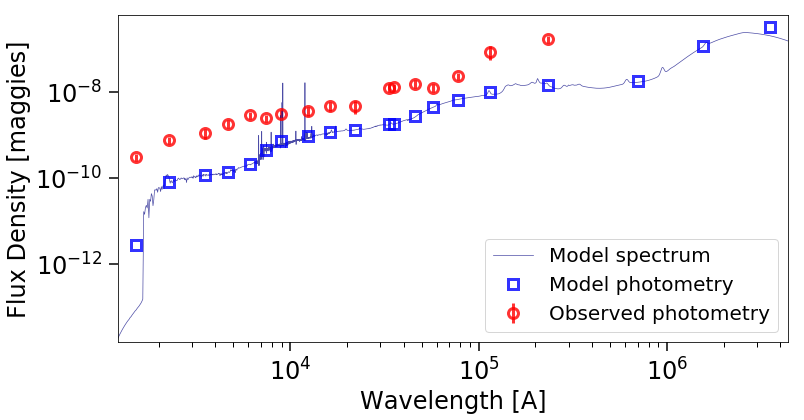

In [23]:
# we can check our simulated SED using inital value
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac =  model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(12,6))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
#plt.plot(obs['wavelength'],obs['spectrum'],'r',alpha=0.1)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)

# Get ready for minimization

In [24]:
# Here we will run all our building functions
obs = build_obs(fit_data,**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# we are using
print(sps.ssp.libraries)

('mist', 'miles')


In [25]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 5
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print("Done optmization in {}s".format(output["optimization"][1]))

/home/kaiwen/.local/lib/python2.7/site-packages/prospect-0.3.0-py2.7.egg/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log


Done optmization in 417.230563879s


[ 0.  10.   0.3  5.  -0.5 -0.5  0.5  1.   0.   0.   0.   0.   0.   0. ]
0
[ 0.  10.   0.3  5.  -0.5  0.   0.5  1.   0.   0.   0.   0.   0.   0. ]


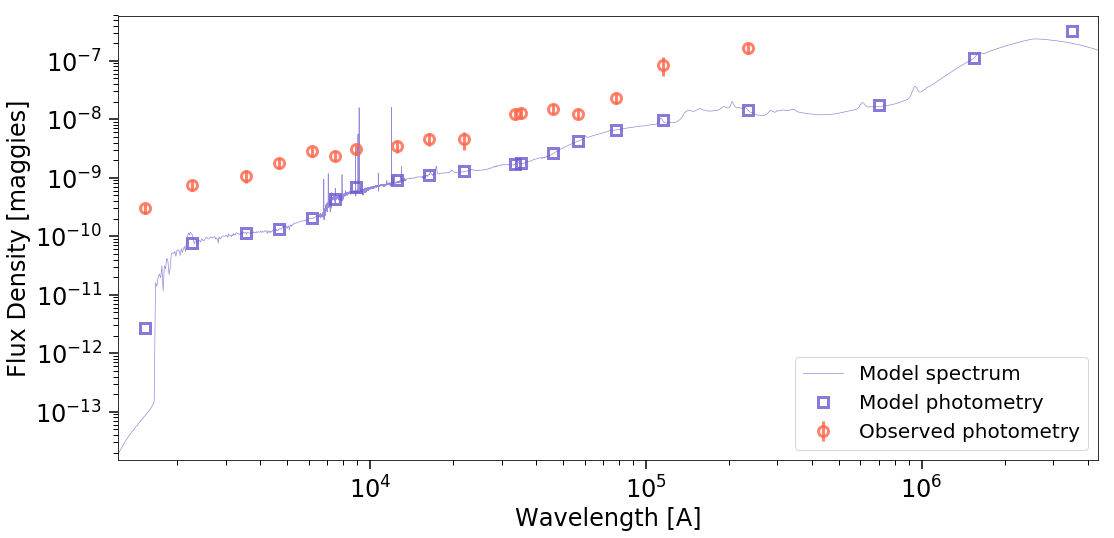

In [26]:
# check the minimization performance
print(theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])

print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)
 
# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
'''loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)'''
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)
#plt.plot(obs['wavelength'],obs['spectrum'],'r',alpha=0.1)

# plot filter transmission curves
'''for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)'''

# bound
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, pspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

# MCMC optimization (brutal force)

In [28]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
# I would not consider dynesty, as its effiency is much lower (you could wait several days for nothing)
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False 
# Number of emcee walkers
# Could be more based on computering power, ~50 should be enough.
run_params["nwalkers"] = 36
# Number of iterations of the MCMC sampling
# I would recommend 6000 ~ 10000 iterations.
run_params["niter"] = 8000
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
# in general 10% of total iter, the iterations below are independent from run_params["niter"]
run_params["nburn"] = [300, 800, 1500]

In [ ]:
# start mcmc process, usually take 8-10h (depend on nwalkers, niter and your single core performance).
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params) 
print('done emcee in {0}s'.format(output["sampling"][1]))

In [ ]:
# after done, it is time to store all the result for later use
from prospect.io import write_results as writer
hfile = "paper_hengxiao.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1], 
                  toptimize=output["optimization"][1])   
print('Finished')

# Read results

In [29]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from("paper_hengxiao.h5".format(results_type), dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

[u'initial_theta', 'model', 'optimization_results', u'prospector_version', u'chain', u'theta_labels', u'sampling_duration', u'model_params', u'optimizer_duration', u'acceptance', u'rstate', u'sampling_initial_center', u'run_params', u'lnprobability', u'paramfile_text', 'obs']


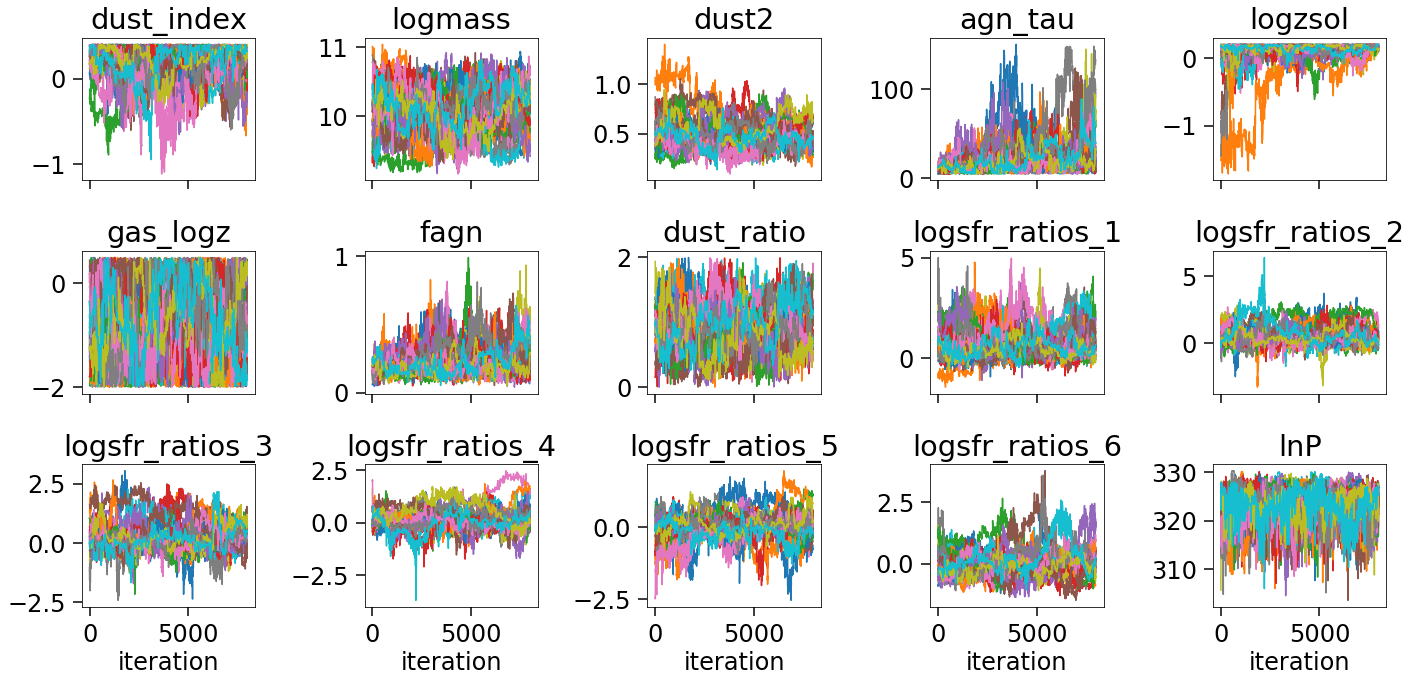

In [30]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=30, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))

MAP value: [ 0.38276063 10.43482547  0.53458751 15.10302115  0.16604701 -1.88642935
  0.1797144   1.05253261  0.26297181  0.49012002  0.1227347   0.08226604
  0.20499129 -0.07344215]


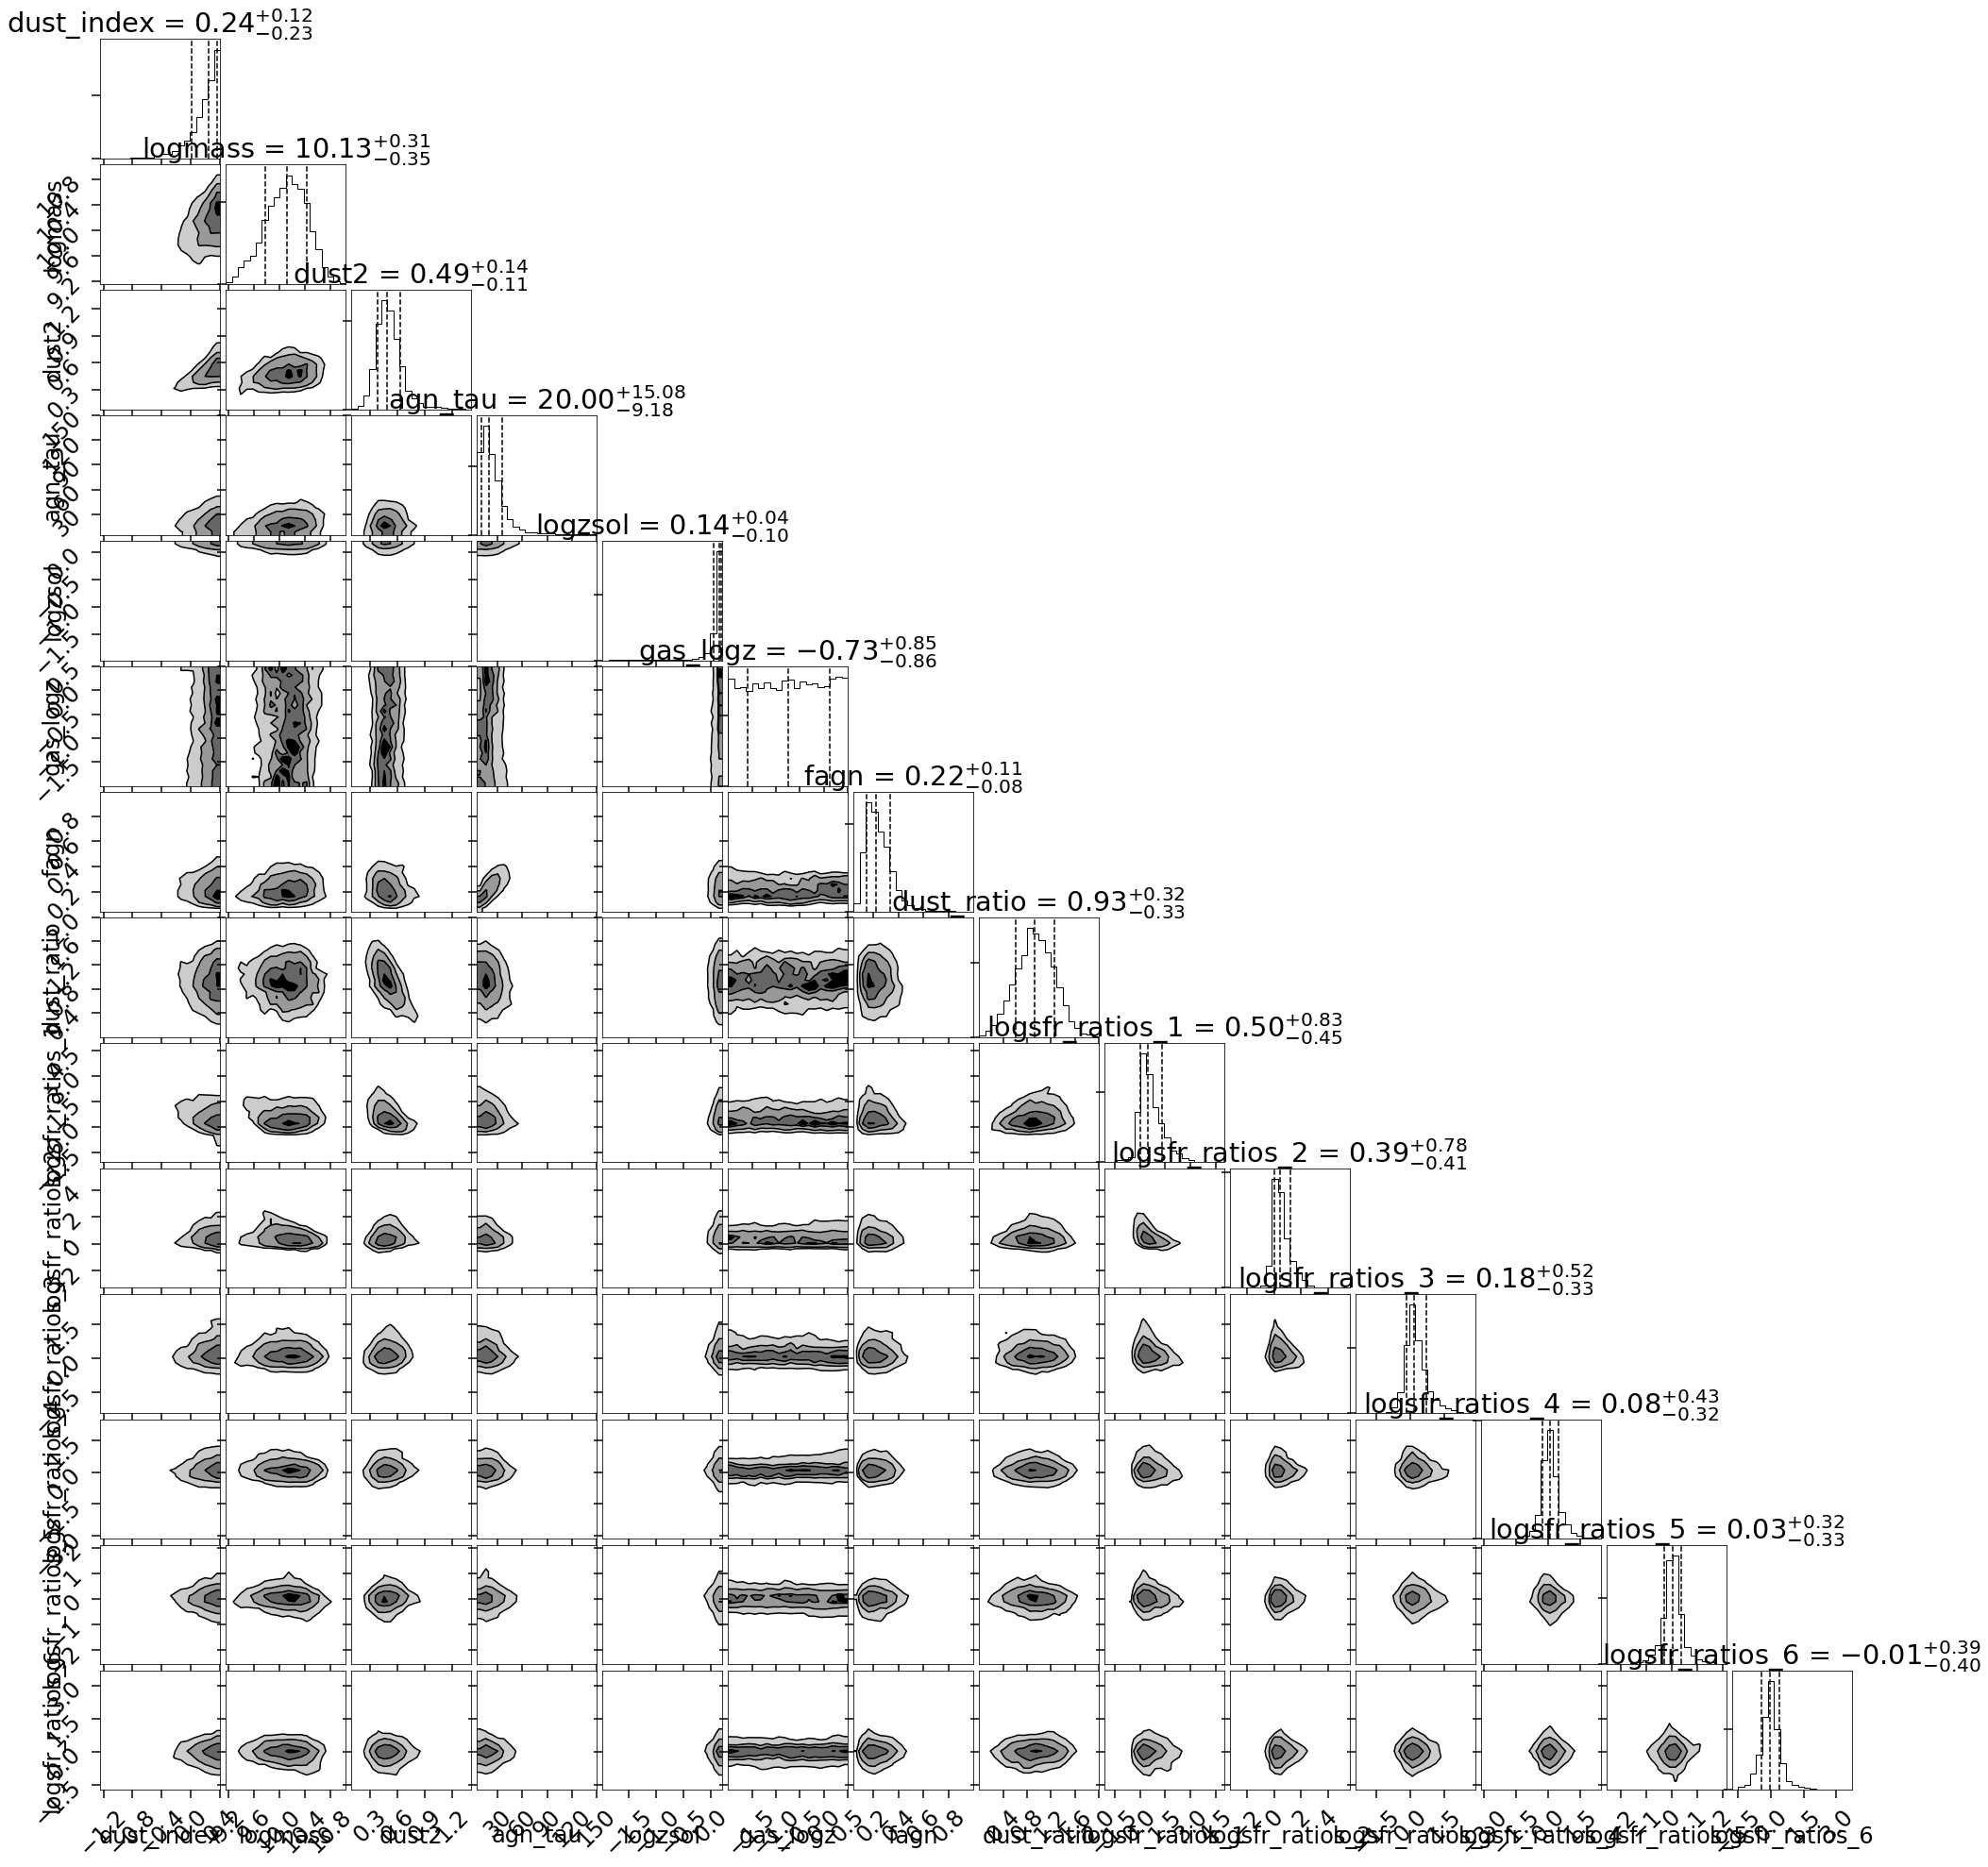

In [31]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

#print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, 
                             fig=subplots(14,14,figsize=(27,27))[0])

# Draw the final fitting plot

In [33]:
a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

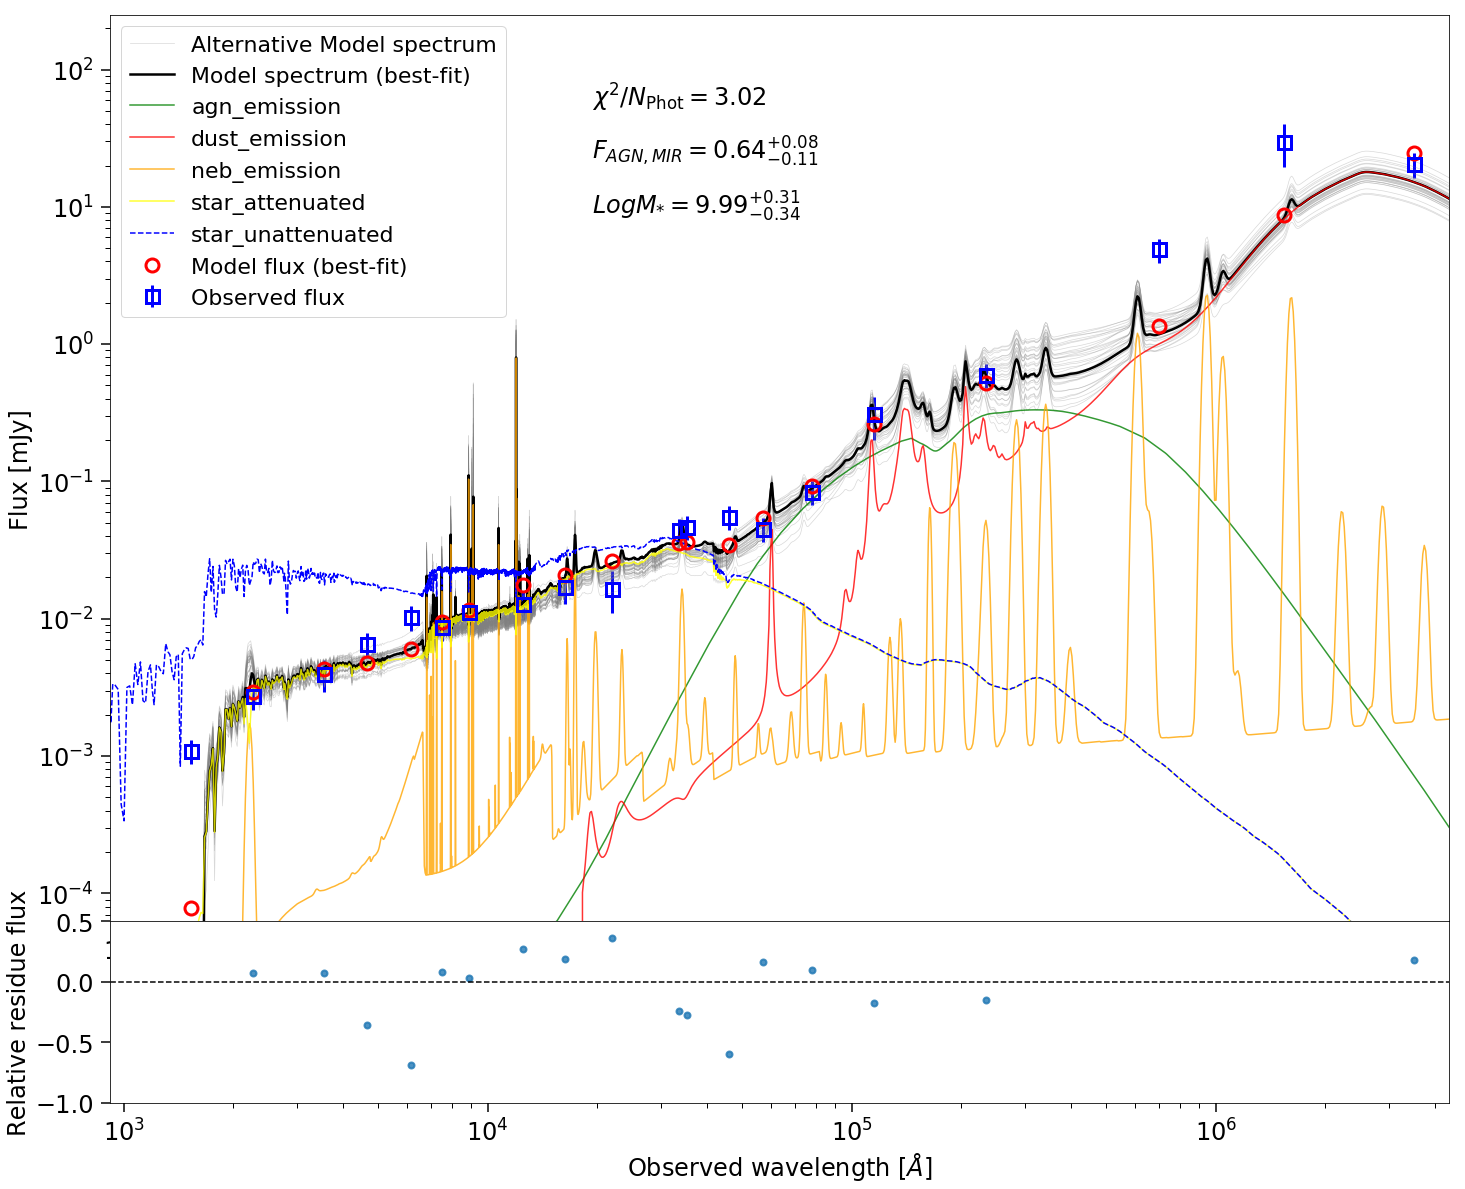

In [37]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    
    # Draw 100 random plots from mcmc
    gs = gridspec.GridSpec(2, 21, height_ratios=[2, 0.4]) 
    gs.update(wspace=0.05, hspace=0)
    ######
    
    figure(figsize=(24,20))
    plt.subplots_adjust(hspace=.0)
    ax1 = plt.subplot(gs[0,:])
    
    for i in range(run_params["nwalkers"]):
        # Get data from any random chain
        theta = result['chain'][randint(nwalkers), randint(niter)]
        
        ################################################################
        # Note the mextra below, by definition, it represnts the surving stellar masse of the total mass.
        # Which is to say the mass parameter in prospector model represnts the total formed stellar mass.
        # And what we want is the surving mass, so the correct way is to using the mass distribution and 
        # mextra to construct a surving mass distrubution. Since mextra is usually from 0.62 to 0.67, thus
        # the more power efficient way to estimate the galaxy mass is finding mextra of the best-fit model 
        # and multiplying the median of total mass.
        mspec_t, mphot_t, mextra = model.mean_model(theta, obs, sps=sps)
        ################################################################
        
        '''# unit conversion to erg/cm^2/s
        mspec = (mspec_t*1e-23)*3e18/wspec
        mphot = (mphot_t*1e-23)*3e18/wphot'''
        mspec = mspec_t*3631*1000
        mphot = mphot_t*3631*1000
        # plot them out
        if i == 0:
            ax1.loglog(wspec, mspec,label='Alternative Model spectrum',
       lw=0.7, color='grey', alpha=0.3)
        else:
            ax1.loglog(wspec, mspec,
       lw=0.7, color='grey', alpha=0.3)
            
else:
    theta = result["chain"][randint(len(result["chain"]))]

# now do it again for the best fit model
mspec_map_t, mphot_map_t, _ = model.mean_model(theta_max, obs, sps=sps)

# units conversion
mspec_map = mspec_map_t*3631*1000
mphot_map = mphot_map_t*3631*1000
ob = obs['maggies']*3631*1000
ob_unc = obs['maggies_unc']*3631*1000
mspec_map_neb,mspec_map_dust,mspec_map_agn,mspec_map_att,mspec_map_un = component(run_params,obs,mspec_map,theta_max)

# calculate reduced chi^2 
chi = np.float128(0)
for i in range(len(wphot)):
    var = np.float128(ob_unc[i])
    chi += np.float128((mphot_map[i] - ob[i])**2)/var**2

# Plot final plots for the best fit model
ax1.loglog(wspec, mspec_map, label='Model spectrum (best-fit)',
       lw=2.5, color='black', alpha=1)
ax1.errorbar(wphot, mphot_map, label='Model flux (best-fit)',
         marker='o', markersize=13, alpha=1, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
ax1.errorbar(wphot, ob, yerr=ob_unc, 
         label='Observed flux', ecolor='blue', 
         marker='s', markersize=13, ls='', lw=3, alpha=1, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
ax1.loglog(wspec, mspec_map_agn, label='agn_emission',
       lw=1.5, color='green', alpha=0.8)
ax1.loglog(wspec, mspec_map_dust, label='dust_emission',
       lw=1.5, color='red', alpha=0.8)
ax1.loglog(wspec, mspec_map_neb, label='neb_emission',
       lw=1.5, color='orange', alpha=0.8)
ax1.loglog(wspec, mspec_map_att, label='star_attenuated',
       lw=1.5, color='yellow', alpha=0.8)
ax1.loglog(wspec, mspec_map_un, label='star_unattenuated',
       lw=1.5, color='blue',linestyle='dashed')

# Setup bound for those plots
xmin, xmax = np.min(wphot)*0.6, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wphot, mphot_map)
ymin, ymax = temp.min()*0.8, temp.max()*10
ax1.set_ylabel('Flux [mJy]',fontsize=24)
ax1.set_ylim([ymin, ymax])
ax1.legend(loc='upper left', fontsize=22)

text(0.36, 0.91,r'${\chi}^2$'+r'$/N_{\rm Phot}  = 3.02$', ha='left', va='center', fontsize=24, transform=ax1.transAxes)
text(0.36, 0.79,r'$Log {M_{*}} = 9.99^{+0.31}_{-0.34}$', ha='left', va='center', fontsize=24, transform=ax1.transAxes)
text(0.36, 0.85,r'$F_{AGN,MIR} = 0.64^{+0.08}_{-0.11}$', ha='left', va='center', fontsize=24, transform=ax1.transAxes)

# plot residue as subplot
x = np.linspace(0, 3e7, 1000)
y = np.empty(1000)
y.fill(0)
ax2 = plt.subplot(gs[1,:], sharex = ax1)
import pylab
residue = (mphot_map - ob)/mphot_map
ax2.scatter(wphot,(mphot_map - ob)/mphot_map,
       lw = 2, alpha = 0.8)
ax2.plot(x,y,linestyle='dashed',color = 'k')
ax2.set_xscale("log")
temp = np.interp(np.linspace(xmin,xmax,10000),wphot, residue)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
ax2.set_xlabel('Observed wavelength [$\AA$]',fontsize=24)
ax2.set_ylabel('Relative residue flux',fontsize=24)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim(-1.0,0.5)
ax2.yaxis.set_ticks(np.linspace(-1.0,0.5,4))